# U-Net

## Hyperparameters

In [1]:
DATASET_NAME = "oxford_flowers102"
IMAGE_SIZE = 64   
BATCH_SIZE = 32
EPOCHS = 16
FILTERS = 8
PATIENCE = 4
DEPTH = 2
ALPHA = 1 - 0.125

## Load the Dataset

In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf

tf.keras.utils.set_random_seed(0)

dataset: dict[str, tf.data.Dataset] = tfds.load(DATASET_NAME)


def add_noise(image: tf.Tensor) -> tf.Tensor:
    noise = tf.random.normal(image.shape)
    return tf.math.sqrt(ALPHA) * image + (1 - ALPHA) * noise


def preprocess_data(data: dict[str, tf.Tensor]) -> tuple[tf.Tensor, tf.Tensor]:
    image = data["image"]
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = image / 255.0
    return add_noise(image), image


def preprocess_dataset(dataset: tf.data.Dataset) -> tf.data.Dataset:
    return dataset.map(preprocess_data).batch(BATCH_SIZE, drop_remainder=True)


train = preprocess_dataset(dataset["train"])
test = preprocess_dataset(dataset["test"])
validation = preprocess_dataset(dataset["validation"])

/home/melidon/egyetem/msc/2_felev/melytanulas/nhf/.env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-11-18 12:55:43.939837: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-18 12:55:43.968975: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-18 12:55:43.969008: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-18 12:55:43.969037: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register 

## Create the U-Net Model

In [3]:
from typing import Callable


def create_u_net(depth: int, filters: int) -> Callable[[tf.Tensor], tf.Tensor]:
    def residual_block(depth: int, filters: int) -> Callable[[tf.Tensor], tf.Tensor]:
        def apply(x: tf.Tensor) -> tf.Tensor:
            x = tf.keras.layers.Conv2D(
                filters,
                (3, 3),
                activation=tf.keras.activations.relu,
                padding="same",
            )(x)
            x = tf.keras.layers.Conv2D(
                filters,
                (3, 3),
                activation=tf.keras.activations.relu,
                padding="same",
            )(x)
            if depth == 0:
                return x
            y = tf.keras.layers.MaxPooling2D((2, 2))(x)
            y = residual_block(depth=depth - 1, filters=filters * 2)(y)
            y = tf.keras.layers.UpSampling2D((2, 2))(y)
            # I don't know how to crop so I use Conv2D to halve the number of channels
            y = tf.keras.layers.Conv2D(
                filters,
                (1, 1),
            )(y)
            x = tf.keras.layers.add([x, y])
            x = tf.keras.layers.Conv2D(
                filters,
                (3, 3),
                activation=tf.keras.activations.relu,
                padding="same",
            )(x)
            x = tf.keras.layers.Conv2D(
                filters,
                (3, 3),
                activation=tf.keras.activations.relu,
                padding="same",
            )(x)
            return x

        return apply

    def apply(x: tf.Tensor) -> tf.Tensor:
        residual_blocks = residual_block(depth=depth, filters=filters)(x)
        output_layer = tf.keras.layers.Conv2D(
            3,
            (1, 1),
            activation=tf.keras.activations.sigmoid,
        )(residual_blocks)
        return output_layer

    return apply


input_layer = tf.keras.layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
)
u_net = create_u_net(depth=DEPTH, filters=FILTERS)(input_layer)
model = tf.keras.Model(inputs=input_layer, outputs=u_net)
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.MeanSquaredError(),
)

## Train the U-Net Model

In [4]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="u_net.h5",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    mode="min",
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=PATIENCE,
    mode="min",
)

history = model.fit(
    train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        early_stopping_callback,
    ],
    validation_data=validation,
)

Epoch 1/16
31/31 [==============================] - 9s 234ms/step - loss: 0.0625 - val_loss: 0.0394
Epoch 2/16
31/31 [==============================] - 6s 210ms/step - loss: 0.0341 - val_loss: 0.0287
Epoch 3/16
31/31 [==============================] - 7s 214ms/step - loss: 0.0264 - val_loss: 0.0250
Epoch 4/16
31/31 [==============================] - 7s 211ms/step - loss: 0.0228 - val_loss: 0.0240
Epoch 5/16
31/31 [==============================] - 7s 214ms/step - loss: 0.0191 - val_loss: 0.0171
Epoch 6/16
31/31 [==============================] - 7s 220ms/step - loss: 0.0165 - val_loss: 0.0159
Epoch 7/16
31/31 [==============================] - 7s 215ms/step - loss: 0.0151 - val_loss: 0.0141
Epoch 8/16
31/31 [==============================] - 7s 216ms/step - loss: 0.0135 - val_loss: 0.0128
Epoch 9/16
31/31 [==============================] - 6s 210ms/step - loss: 0.0118 - val_loss: 0.0108
Epoch 10/16
31/31 [==============================] - 7s 214ms/step - loss: 0.0100 - val_loss: 0.0094

## Visualize Train and Validation Loss

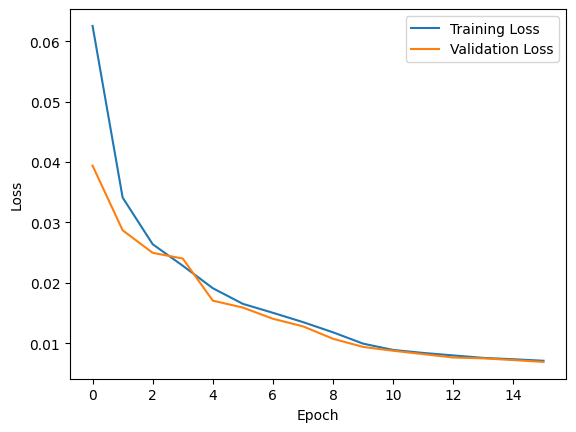

In [5]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

## Visualize the Results

1/1 [==============================] - 0s 351ms/step


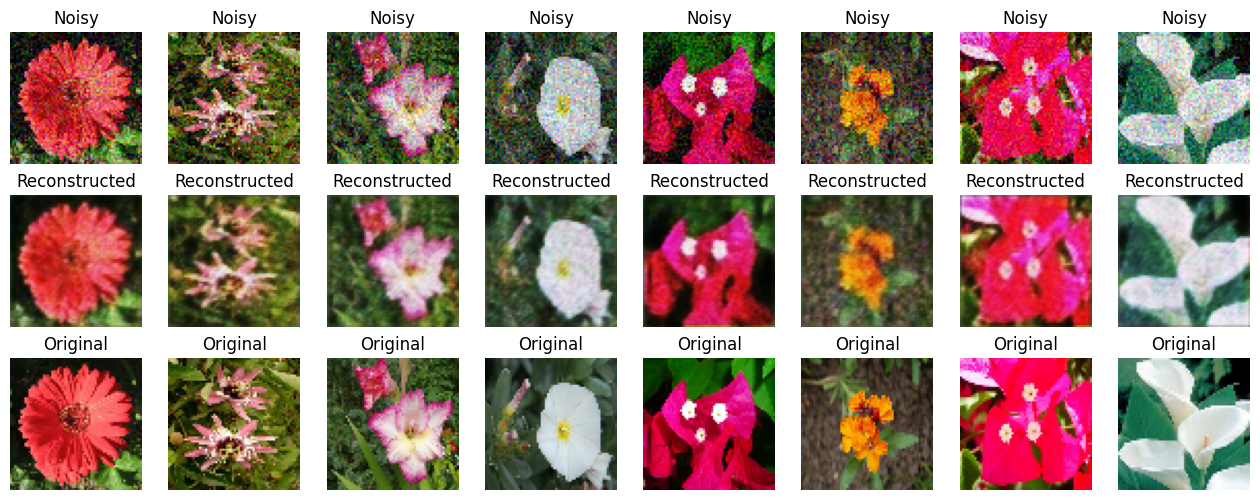

In [6]:
NUMBER_OF_IMAGES = 8
ROWS = 3

model.load_weights("u_net.h5")
noisy_images, original_images = next(iter(test.unbatch().batch(NUMBER_OF_IMAGES)))
reconstructed_images = model.predict(noisy_images)

plt.figure(figsize=(2 * NUMBER_OF_IMAGES, 2 * ROWS))
for i in range(NUMBER_OF_IMAGES):
    plt.subplot(ROWS, NUMBER_OF_IMAGES, i + 0 * NUMBER_OF_IMAGES + 1)
    plt.imshow(noisy_images[i])
    plt.title("Noisy")
    plt.axis("off")

    plt.subplot(ROWS, NUMBER_OF_IMAGES, i + 1 * NUMBER_OF_IMAGES + 1)
    plt.imshow(reconstructed_images[i])
    plt.title("Reconstructed")
    plt.axis("off")

    plt.subplot(ROWS, NUMBER_OF_IMAGES, i + 2 * NUMBER_OF_IMAGES + 1)
    plt.imshow(original_images[i])
    plt.title("Original")
    plt.axis("off")

plt.show()